## EDA

In [ ]:
from pathlib import Path
import os, json, hashlib, random, shutil, time, zipfile, re, math
import cv2, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict, Counter

from IPython.display import display, Image, Markdown
pd.set_option('display.max_rows', None)  #	يخلي الجداول (DataFrame) تطلع كاملة في النوتبوك وما 

CONFIG

In [13]:
DATA_DIR = Path("/Users/amirah/Sila/Data/Row/ArASL_Database_54K_Final")  # ما اقدر ارفع الداتا على القيت هب فغيروا الباث هنا

# Make OUTPUT_DIR absolute so saved files are easy to find
OUTPUT_DIR = (Path().resolve() / "EDA_outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)   #يعمل إنشاء للمجلد و ما يعطي خطأ لو المجلد موجود اصلا 

# Image extensions we accept
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".gif"}

# Random seed for reproducibility (sampling)
RANDOM_SEED = 42   
random.seed(RANDOM_SEED)   #نضمن إن النتائج تبقى نفسها كل مرة نشغل الكود

# Limit how many images to scan per class for expensive checks (None => all)
SIZE_STATS_LIMIT_PER_CLASS = None  
DUP_SCAN_LIMIT_PER_CLASS   = None  

# Toggle optional visuals
ENABLE_PIE_CHART   = True  #رسم Pie Chart لتوزيع الصور حسب الفئات
ENABLE_SAMPLE_GRID = True  #يعرض Grid (شبكة) فيها عينات من الصور
ENABLE_DUP_CHECK   = True  #يفعل فحص التكرارات

هنا بما انهم نبهوا ع الرسومات سويت داله تعرض الروسومات هنا و تنحفظ في ملف خارجي عشان نوصل لها بسرعه

In [14]:
def is_image(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

def safe_imread(path: Path, flags=cv2.IMREAD_UNCHANGED):
    try:
        return cv2.imread(str(path), flags)
    except Exception:
        return None

def md5_of_file(path: Path, chunk_size=1 << 20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

# show & save plots
def savefig_and_show(path, dpi=200):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    plt.show()
    plt.close()

def show_png_file(path):
    display(Image(filename=str(path)))
    
def is_image(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

def safe_imread(path: Path, flags=cv2.IMREAD_UNCHANGED):
    try:
        return cv2.imread(str(path), flags)
    except Exception:
        return None

def md5_of_file(path: Path, chunk_size=1 << 20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

# show & save plots
def savefig_and_show(path, dpi=200):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    plt.show()
    plt.close()

def show_png_file(path):
    display(Image(filename=str(path)))

Report logger 

In [15]:
REPORT_PATH = OUTPUT_DIR / "eda_report.md"  #هذا الملف يجمع كل النصوص + الجداول + الصور اللي نطلعها

def report_start(title="ArASL EDA Report"):    #ينشئ ملف التقرير ويكتب فيه العنوان الرئيسي
    REPORT_PATH.write_text(f"# {title}\n\n", encoding="utf-8")  #يبدأ تقرير جديد كل مرة

def report_section(title, text=None):  #يضيف عنوان فرعي 
    with REPORT_PATH.open("a", encoding="utf-8") as f:
        f.write(f"\n\n## {title}\n\n")
        if text:
            f.write(text + "\n")

def _csv_preview_block(df, rows):
    # embed first rows as a code block CSV (avoids tabulate dependency)
    preview = df.head(rows).to_csv(index=False)
    return f"\n**Preview ({min(rows, len(df))} rows)**:\n\n```\n{preview}\n```\n"

def report_table(caption, df: pd.DataFrame, csv_name: str, show_rows=None):
    csv_path = OUTPUT_DIR / csv_name
    df.to_csv(csv_path, index=False)
    if show_rows is None:
        show_rows = len(df)
    with REPORT_PATH.open("a", encoding="utf-8") as f:
        f.write(f"\n**{caption}** — saved CSV: `{csv_path.name}`\n")
        f.write(_csv_preview_block(df, show_rows))

def report_image(caption, img_path):
    rel = img_path.relative_to(OUTPUT_DIR)
    with REPORT_PATH.open("a", encoding="utf-8") as f:
        f.write(f"\n**{caption}**\n\n![{caption}]({rel.as_posix()})\n")

def report_kv(title, d: dict):
    with REPORT_PATH.open("a", encoding="utf-8") as f:
        f.write(f"\n\n## {title}\n\n")
        for k,v in d.items():
            f.write(f"- **{k}**: {v}\n")

# start report
report_start("ArASL EDA Report")

 LIST CLASSES

In [16]:
def list_classes(data_dir: Path):
    if not data_dir.exists():
        raise SystemExit(f"[ERROR] Dataset not found at: {data_dir}")
    classes = sorted([d for d in data_dir.iterdir() if d.is_dir()], key=lambda p: p.name)
    (OUTPUT_DIR / "classes.txt").write_text("\n".join([c.name for c in classes]), encoding="utf-8")
    return classes

classes = list_classes(DATA_DIR)
report_section("Classes", f"Found **{len(classes)}** classes. Saved list to `classes.txt`.")
display(classes)

[PosixPath('/Users/amirah/Sila/Data/Row/ArASL_Database_54K_Final/ain'),
 PosixPath('/Users/amirah/Sila/Data/Row/ArASL_Database_54K_Final/al'),
 PosixPath('/Users/amirah/Sila/Data/Row/ArASL_Database_54K_Final/aleff'),
 PosixPath('/Users/amirah/Sila/Data/Row/ArASL_Database_54K_Final/bb'),
 PosixPath('/Users/amirah/Sila/Data/Row/ArASL_Database_54K_Final/dal'),
 PosixPath('/Users/amirah/Sila/Data/Row/ArASL_Database_54K_Final/dha'),
 PosixPath('/Users/amirah/Sila/Data/Row/ArASL_Database_54K_Final/dhad'),
 PosixPath('/Users/amirah/Sila/Data/Row/ArASL_Database_54K_Final/fa'),
 PosixPath('/Users/amirah/Sila/Data/Row/ArASL_Database_54K_Final/gaaf'),
 PosixPath('/Users/amirah/Sila/Data/Row/ArASL_Database_54K_Final/ghain'),
 PosixPath('/Users/amirah/Sila/Data/Row/ArASL_Database_54K_Final/ha'),
 PosixPath('/Users/amirah/Sila/Data/Row/ArASL_Database_54K_Final/haa'),
 PosixPath('/Users/amirah/Sila/Data/Row/ArASL_Database_54K_Final/jeem'),
 PosixPath('/Users/amirah/Sila/Data/Row/ArASL_Database_54K_Fi

 COUNT PER CLASS + BAR CHART

Counting images per class: 100%|██████████| 32/32 [00:00<00:00, 558.08it/s]


,class,count
0,ain,2114
1,al,1343
2,aleff,1672
3,bb,1791
4,dal,1634
5,dha,1723
6,dhad,1670
7,fa,1955
8,gaaf,1705
9,ghain,1977


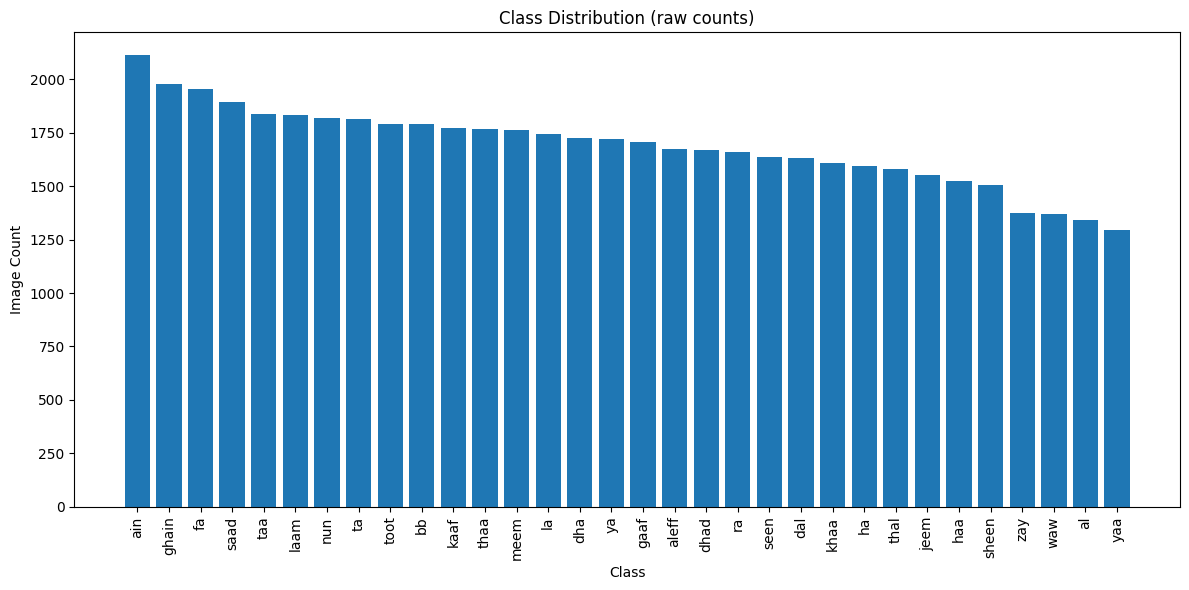

In [21]:
def count_images_per_class(classes):
    rows = []
    for c in tqdm(classes, desc="Counting images per class"):
        n = sum(1 for p in c.iterdir() if is_image(p))
        rows.append({"class": c.name, "count": n})
    df = pd.DataFrame(rows).sort_values("class").reset_index(drop=True)
    return df

df_counts = count_images_per_class(classes)
display(df_counts)
report_table("Class Counts", df_counts, "class_counts.csv", show_rows=len(df_counts))

df_sorted = df_counts.sort_values("count", ascending=False).reset_index(drop=True)
plt.figure(figsize=(12,6))
plt.bar(df_sorted["class"], df_sorted["count"])
plt.xticks(rotation=90)
plt.title("Class Distribution (raw counts)")
plt.xlabel("Class"); plt.ylabel("Image Count")
bar_path = OUTPUT_DIR / "class_distribution.png"
savefig_and_show(bar_path)
report_image("Class Distribution (bar)", bar_path)

ADD PERCENTAGES + PIE

,class,count,percentage
0,ain,2114,3.911266
1,ghain,1977,3.657792
2,fa,1955,3.617088
3,saad,1895,3.506078
4,taa,1838,3.400618
5,laam,1832,3.389517
6,nun,1819,3.365465
7,ta,1816,3.359914
8,toot,1791,3.313660
9,bb,1791,3.313660


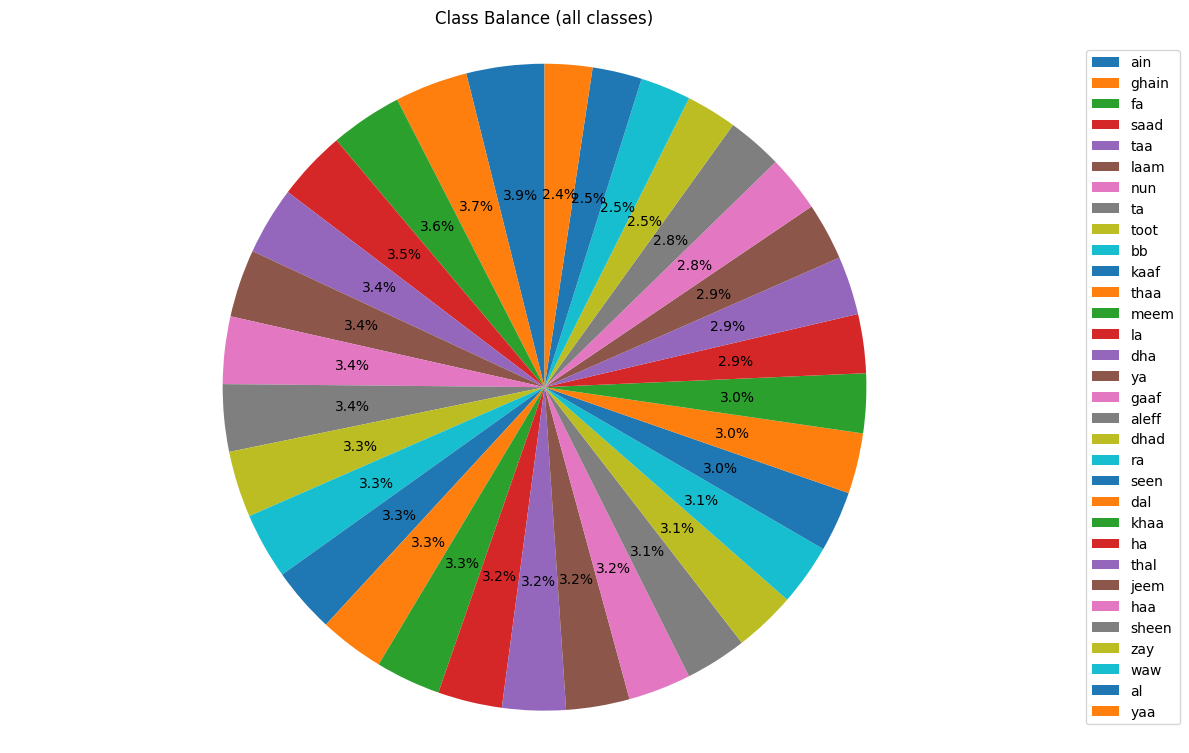

In [22]:
def add_percentages(df_counts: pd.DataFrame):
    total = int(df_counts["count"].sum())
    df2 = df_counts.copy()
    df2["percentage"] = (df2["count"] / total) * 100.0
    df2 = df2.sort_values("count", ascending=False).reset_index(drop=True)
    return df2

df_pct = add_percentages(df_counts)
display(df_pct)
report_table("Class Counts with Percentage", df_pct, "class_counts_with_percentage.csv", show_rows=len(df_pct))

if ENABLE_PIE_CHART:
    plt.figure(figsize=(12,8))
    plt.pie(df_pct["percentage"], autopct="%.1f%%", startangle=90)
    plt.title("Class Balance (all classes)")
    plt.axis('equal')
    plt.legend(df_pct["class"], loc="center left", bbox_to_anchor=(1, 0.5))
    pie_path = OUTPUT_DIR / "class_balance.png"
    savefig_and_show(pie_path)
    report_image("Class Balance (pie)", pie_path)

CORRUPTED IMAGES CHECK

Scanning corrupted images: 100%|██████████| 32/32 [00:05<00:00,  6.11it/s]


,class,corrupted
0,ain,0
1,al,0
30,yaa,0
29,ya,0
28,waw,0
27,toot,0
26,thal,0
25,thaa,0
24,taa,0
23,ta,0


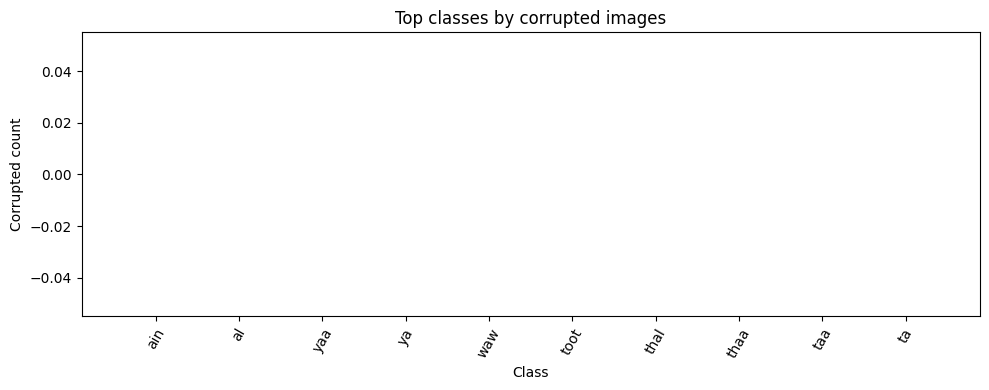

In [23]:
def find_corrupted_images(classes):
    bad_files, per_class = [], []
    for c in tqdm(classes, desc="Scanning corrupted images"):
        bad_in_class = 0
        for p in c.iterdir():
            if not is_image(p):
                continue
            im = safe_imread(p)
            if im is None:
                bad_files.append(str(p))
                bad_in_class += 1
        per_class.append({"class": c.name, "corrupted": bad_in_class})
    df_bad = pd.DataFrame(per_class).sort_values("corrupted", ascending=False)
    if bad_files:
        with open(OUTPUT_DIR / "corrupted_images.json", "w", encoding="utf-8") as f:
            json.dump(bad_files, f, ensure_ascii=False, indent=2)
    return bad_files, df_bad

bad_files, bad_df = find_corrupted_images(classes)
display(bad_df)
report_table("Corrupted Images per Class", bad_df, "corrupted_counts_per_class.csv", show_rows=len(bad_df))
report_section("Corrupted Summary", f"Total corrupted files: **{len(bad_files)}**" + (", saved to `corrupted_images.json`" if bad_files else ""))

# optional top-10 bar
top_bad = bad_df.head(10)
plt.figure(figsize=(10,4))
plt.bar(top_bad["class"], top_bad["corrupted"])
plt.xticks(rotation=60)
plt.title("Top classes by corrupted images")
plt.xlabel("Class"); plt.ylabel("Corrupted count")
corr_path = OUTPUT_DIR / "corrupted_top10.png"
savefig_and_show(corr_path)
report_image("Top classes by corrupted images", corr_path)

RANDOM SAMPLE GRID

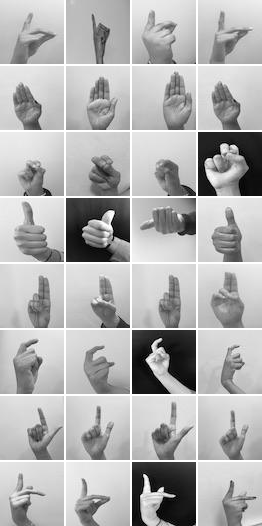

In [29]:
def save_sample_grid(classes, max_classes=8, samples_per_class=4, tile_size=(64,64)):
    try:
        chosen = random.sample(classes, k=min(max_classes, len(classes)))
    except ValueError:
        chosen = classes
    tiles = []
    for c in chosen:
        imgs = [p for p in c.iterdir() if is_image(p)]
        random.shuffle(imgs)
        imgs = imgs[:samples_per_class]
        for p in imgs:
            im = safe_imread(p, flags=cv2.IMREAD_GRAYSCALE)
            if im is None: 
                continue
            im = cv2.resize(im, tile_size, interpolation=cv2.INTER_AREA)
            tiles.append(im)
    if not tiles:
        return None
    rows, cols = max_classes, samples_per_class
    rows = min(rows, int(np.ceil(len(tiles)/max(1, cols))))
    h, w = tile_size
    pad = 2
    grid = np.full((rows*(h+pad)-pad, cols*(w+pad)-pad), 255, dtype=np.uint8)
    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx >= len(tiles): break
            rh, ch = r*(h+pad), c*(w+pad)
            grid[rh:rh+h, ch:ch+w] = tiles[idx]
            idx += 1
    out_path = OUTPUT_DIR / "sample_grid.png"
    cv2.imwrite(str(out_path), grid)
    return out_path

if ENABLE_SAMPLE_GRID:
    grid_path = save_sample_grid(classes, max_classes=8, samples_per_class=4, tile_size=(64,64))
    if grid_path:
        show_png_file(grid_path)
        report_image("Sample Grid", grid_path)

DUPLICATE CHECK

In [30]:

def find_duplicates_by_hash(classes, limit_per_class=None):
    dup_report, total_dups = {}, 0
    for c in tqdm(classes, desc="Duplicate scan (md5)"):
        files = [p for p in c.iterdir() if is_image(p)]
        if limit_per_class is not None:
            files = files[:limit_per_class]
        seen, dups = {}, []
        for p in files:
            try:
                h = md5_of_file(p)
            except Exception:
                continue
            if h in seen:
                dups.append(str(p))
            else:
                seen[h] = str(p)
        if dups:
            dup_report[c.name] = {"duplicates": dups, "kept_example": next(iter(seen.values()))}
            total_dups += len(dups)
    if dup_report:
        with open(OUTPUT_DIR / "duplicates_by_class.json", "w", encoding="utf-8") as f:
            json.dump(dup_report, f, ensure_ascii=False, indent=2)
    return dup_report, total_dups

dups, total_dups = ({}, 0)
if ENABLE_DUP_CHECK:
    dups, total_dups = find_duplicates_by_hash(classes, limit_per_class=DUP_SCAN_LIMIT_PER_CLASS)

report_section("Duplicates Summary", f"Total duplicate files (scanned): **{total_dups}**" + (" (see `duplicates_by_class.json`)" if total_dups else ""))

if dups:
    df_dups_per_class = (
        pd.DataFrame([{"class": k, "duplicates": len(v["duplicates"])} for k,v in dups.items()])
        .sort_values("duplicates", ascending=False)
        .reset_index(drop=True)
    )
    display(df_dups_per_class)
    report_table("Duplicates per Class", df_dups_per_class, "duplicates_per_class.csv", show_rows=len(df_dups_per_class))
else:
    print("No duplicates detected in the scanned set.")

Duplicate scan (md5): 100%|██████████| 32/32 [00:03<00:00,  8.49it/s]


,class,duplicates
0,ya,206
1,aleff,199
2,khaa,195
3,saad,193
4,thaa,193
5,taa,193
6,ain,191
7,thal,191
8,dal,191
9,jeem,190


MAIN

In [34]:
# corrupted count (if file exists)
corr_json = OUTPUT_DIR / "corrupted_images.json"
corrupted_count = 0
if corr_json.exists():
    with open(corr_json, encoding="utf-8") as f:
        corrupted_count = len(json.load(f))

summary_md = (
    f"- Classes: **{len(classes)}**\n"
    f"- Total images: **{int(df_counts['count'].sum())}**\n"
    f"- Corrupted files: **{corrupted_count}**\n"
    f"- Duplicates (scanned): **{total_dups}**\n"
    f"- Outputs folder: `{OUTPUT_DIR.name}`\n"
    f"- Report file: `{REPORT_PATH.name}`\n"
)

display(Markdown("## Final Summary\n\n" + summary_md))
report_section("Final Summary", summary_md)

## Final Summary

- Classes: **32**
- Total images: **54049**
- Corrupted files: **0**
- Duplicates (scanned): **5627**
- Outputs folder: `EDA_outputs`
- Report file: `eda_report.md`


## Cleaning

IMPORTS & CONFIG

In [35]:
# هنا بنحفظ النسخة النظيفة بعد التنظيف
CLEAN_DIR  = Path("./ArASL_Cleaned")

#مجلد لحفظ التقارير والسجلات أثناء التنظيف
CLEAN_LOGS = Path("./clean_logs")
CLEAN_LOGS.mkdir(parents=True, exist_ok=True) #عن التكرارات، الصور المحذوفة، الملخص

# اعدادات معالجة الصور
TARGET_SIZE = (64, 64)     # كل الصور بعد التنظيف راح تنعاد تحجيمها لمقاس 64
TO_GRAYSCALE = True        # نحول الصورة الى رمادي (مفيد للغة الاشارة)
IMG_EXTS      = {".png", ".jpg", ".jpeg", ".bmp"}

# التعامل مع التكرارات
DEDUP_SCOPE = "per_class"  # هذا يحدد كيف نفحص التكرارات
DEDUP_ACTION  = "delete"         # حذف نهائي من المصدر

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

HELPERS

In [36]:
def is_image(p: Path) -> bool:
    # نتاكد ان الملف صورة من الامتداد
    return p.suffix.lower() in IMG_EXTS

def safe_imread(path: Path, flags=cv2.IMREAD_UNCHANGED):
    # قراءة آمنة؛ ترجع None لو الصورة تالفة
    try:
        return cv2.imread(str(path), flags)
    except Exception:
        return None

def md5_of_file(path: Path, chunk_size=1<<20):
    #  بصمة الملف (للكشف عن التكرار)
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)
    return p

def write_json(obj, path: Path):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

SCAN CLASSES & FILES

In [37]:
assert DATA_DIR.exists(), f"Dataset not found at {DATA_DIR}"

classes = sorted([d for d in DATA_DIR.iterdir() if d.is_dir()], key=lambda p: p.name)
assert classes, "No class folders found."

# دخلنا داخل كل كلاس وجمعنا الصور
all_items = []
for c in classes:
    files = [p for p in c.iterdir() if is_image(p)]
    for p in files:
        all_items.append({"class": c.name, "path": p})

df_files = pd.DataFrame(all_items) # حولناها لجدول (DataFrame)
print(f"[INFO] classes: {len(classes)} | images: {len(df_files)}")
display(df_files.head(3))

[INFO] classes: 32 | images: 54049


,class,path
0,ain,/Users/amirah/Sila/Data/Row/ArASL_Database_54K...
1,ain,/Users/amirah/Sila/Data/Row/ArASL_Database_54K...
2,ain,/Users/amirah/Sila/Data/Row/ArASL_Database_54K...


In [38]:
df_files["class"].unique() #هوس اني اشيك كل مره

array(['ain', 'al', 'aleff', 'bb', 'dal', 'dha', 'dhad', 'fa', 'gaaf',
       'ghain', 'ha', 'haa', 'jeem', 'kaaf', 'khaa', 'la', 'laam', 'meem',
       'nun', 'ra', 'saad', 'seen', 'sheen', 'ta', 'taa', 'thaa', 'thal',
       'toot', 'waw', 'ya', 'yaa', 'zay'], dtype=object)

DUPLICATE DETECTION

In [39]:
assert DEDUP_SCOPE == "per_class", "This notebook implements 'per_class' only."

dups_map = {}      # (class, hash) -> {"keep": Path, "dups": [Path, ...]}
hash_of_path = {}

for cls in tqdm(sorted(df_files["class"].unique()), desc="Hashing (per class)"):
    sub = df_files[df_files["class"] == cls]
    seen = {}  # hash -> first path (keep)
    for _, row in sub.iterrows():
        h = md5_of_file(row["path"])
        hash_of_path[row["path"]] = h
        key = (cls, h)
        if h in seen:
            if key not in dups_map:
                dups_map[key] = {"keep": seen[h], "dups": []}
            dups_map[key]["dups"].append(row["path"])
        else:
            seen[h] = row["path"]

# Normalize → table + list to remove (robust لو ما فيه مكررات)
to_remove = set()
dup_rows = []
for (cls, h), rec in dups_map.items():
    if not rec.get("dups"):
        continue
    for p in rec["dups"]:
        to_remove.add(p)
    dup_rows.append({
        "scope": cls,
        "hash":  h,
        "kept":  str(rec["keep"]),
        "duplicates": len(rec["dups"]),
    })

if dup_rows:
    df_dups = pd.DataFrame(dup_rows).sort_values("duplicates", ascending=False).reset_index(drop=True)
else:
    df_dups = pd.DataFrame(columns=["scope", "hash", "kept", "duplicates"])

print(f"[INFO] duplicates found (files to remove): {len(to_remove)}")
if not df_dups.empty:
    display(df_dups.head(10))
else:
    print("[INFO] No duplicate groups detected.")

# حفظ الملخصات
write_json({"duplicates_to_remove": list(map(str, to_remove))}, CLEAN_LOGS / "duplicates_to_remove.json")
df_dups.to_csv(CLEAN_LOGS / "duplicates_summary.csv", index=False)

Hashing (per class): 100%|██████████| 32/32 [00:05<00:00,  5.81it/s]

[INFO] duplicates found (files to remove): 5627


,scope,hash,kept,duplicates
0,ain,64e7ee0539cf00096b151f984a75d30c,/Users/amirah/Sila/Data/Row/ArASL_Database_54K...,19
1,ra,ec7d6cbb8809f8984f154f7c3c82695c,/Users/amirah/Sila/Data/Row/ArASL_Database_54K...,19
2,ra,b42553cb2c5150c80cfefa3974204470,/Users/amirah/Sila/Data/Row/ArASL_Database_54K...,19
3,ra,856e41e752670bf5066696b23f0063ad,/Users/amirah/Sila/Data/Row/ArASL_Database_54K...,19
4,ra,30aeeb4890a170c52c46687c1d2cd7f0,/Users/amirah/Sila/Data/Row/ArASL_Database_54K...,19
5,nun,ea0bfa9dadf46bd95ca508bd72137745,/Users/amirah/Sila/Data/Row/ArASL_Database_54K...,19
6,nun,b87bf4c7d8ffc6bc0c4ef5c780e1ab5e,/Users/amirah/Sila/Data/Row/ArASL_Database_54K...,19
7,nun,0a42718fe85b2451a6f7c727178aca51,/Users/amirah/Sila/Data/Row/ArASL_Database_54K...,19
8,nun,84e77754fdf64f80ccb2b5d142793bee,/Users/amirah/Sila/Data/Row/ArASL_Database_54K...,19
9,nun,5fcc5542be3a0ee99b31245ddf92dfaa,/Users/amirah/Sila/Data/Row/ArASL_Database_54K...,19


APPLY DEDUP ACTION (DELETE)


In [40]:
assert DEDUP_ACTION == "delete", "Set DEDUP_ACTION='delete' to actually remove duplicates."

removed_list = []
for p in tqdm(list(to_remove), desc="Deleting duplicates"):
    try:
        p.unlink(missing_ok=True)  # حذف نهائي
        removed_list.append(str(p))
    except Exception as e:
        print("[WARN]", e)

write_json({"duplicates_removed": removed_list, "mode": DEDUP_ACTION}, CLEAN_LOGS / "duplicates_removed.json")
print(f"[INFO] duplicates removed from source: {len(removed_list)} | mode: {DEDUP_ACTION}")

# إعادة مسح بعد الحذف
all_items = []
for c in classes:
    for p in c.iterdir():
        if is_image(p):
            all_items.append({"class": c.name, "path": p})
df_files = pd.DataFrame(all_items)
print(f"[INFO] post-dedup images: {len(df_files)}")

Deleting duplicates: 100%|██████████| 5627/5627 [00:00<00:00, 15874.77it/s]


[INFO] duplicates removed from source: 5627 | mode: delete
[INFO] post-dedup images: 48422


RESCAN AFTER DEDUP


In [41]:
all_items = []
for c in classes:
    for p in c.iterdir():
        if is_image(p):
            all_items.append({"class": c.name, "path": p})
df_files = pd.DataFrame(all_items)
print(f"[INFO] post-dedup images: {len(df_files)}")

[INFO] post-dedup images: 48422


PREPROCESS HELPERS (GRAY + PAD + RESIZE)


In [42]:
def preprocess_img(img):
    #  نحول الصورة إلى رمادي لو كانت ملوّنة (BGR/BGRA)
    if TO_GRAYSCALE and img.ndim == 3:
        if img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def resize_keep_aspect(img, target_size=(64, 64), pad_value=255):
    # نحافظ على نسبة الأبعاد عبر padding لمربع ثم resize نهائي
    tw, th = target_size  # width, height
    h, w = img.shape[:2]
    side = max(h, w)

    # كانفاس أبيض
    if img.ndim == 2:
        canvas = np.full((side, side), pad_value, dtype=img.dtype)
    else:
        canvas = np.full((side, side, img.shape[2]), pad_value, dtype=img.dtype)

    # وضع الصورة في المنتصف
    y0 = (side - h) // 2
    x0 = (side - w) // 2
    canvas[y0:y0 + h, x0:x0 + w] = img

    # تغيير المقاس النهائي
    out = cv2.resize(canvas, (tw, th), interpolation=cv2.INTER_AREA)
    return out

BUILD CLEANED DATASET

In [43]:
# تجهيز مجلدات الكلاسات في CLEAN_DIR
for c in classes:
    (CLEAN_DIR / c.name).mkdir(parents=True, exist_ok=True)

skipped_corrupted = 0
written_count = 0

progress = tqdm(total=len(df_files), desc="Copying -> CLEAN_DIR")
for _, row in df_files.iterrows():
    src = row["path"]
    cls = row["class"]

    # 1) قراءة آمنة
    im = safe_imread(src)
    if im is None:
        skipped_corrupted += 1
        progress.update(1)
        continue

    # 2) تحويل لرمادي (إن مفعّل)
    im = preprocess_img(im)

    # 3) padding + resize
    im = resize_keep_aspect(im, TARGET_SIZE, pad_value=255)

    # 4) حفظ كـ PNG (قناة وحدة لو رمادي)
    dst = CLEAN_DIR / cls / (src.stem + ".png")
    if im.ndim == 2:
        cv2.imwrite(str(dst), im)
    else:
        cv2.imwrite(str(dst), cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

    written_count += 1
    progress.update(1)

progress.close()
print(f"[INFO] written: {written_count} | corrupted skipped: {skipped_corrupted}")

Copying -> CLEAN_DIR: 100%|██████████| 48422/48422 [00:10<00:00, 4614.59it/s]

[INFO] written: 48422 | corrupted skipped: 0


VERIFY CLEANED COUNTS & SUMMARY

In [44]:
rows = []
for c in sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name):
    n = sum(1 for p in c.iterdir() if is_image(p))
    rows.append({"class": c.name, "count": n})

df_clean_counts = pd.DataFrame(rows).sort_values("class").reset_index(drop=True)
display(df_clean_counts)

# حفظ التقارير
df_clean_counts.to_csv(CLEAN_LOGS / "clean_counts.csv", index=False)

total_clean = int(df_clean_counts["count"].sum())
summary = {
    "source_dir": str(DATA_DIR.resolve()),
    "clean_dir":  str(CLEAN_DIR.resolve()),
    "target_size": TARGET_SIZE,
    "to_grayscale": TO_GRAYSCALE,
    "dedup_scope":  DEDUP_SCOPE,
    "dedup_action": DEDUP_ACTION,
    "total_clean_images": total_clean
}
write_json(summary, CLEAN_LOGS / "clean_summary.json")

print("\n[DONE] Cleaning finished.")
print("Clean dir:", CLEAN_DIR.resolve())
print("Total images:", total_clean)

,class,count
0,ain,1923
1,al,1341
2,aleff,1473
3,bb,1604
4,dal,1443
5,dha,1552
6,dhad,1483
7,fa,1766
8,gaaf,1516
9,ghain,1788



[DONE] Cleaning finished.
Clean dir: /Users/amirah/Sila/Src/ArASL_Cleaned
Total images: 48422


SAMPLE GRID FROM CLEANED 


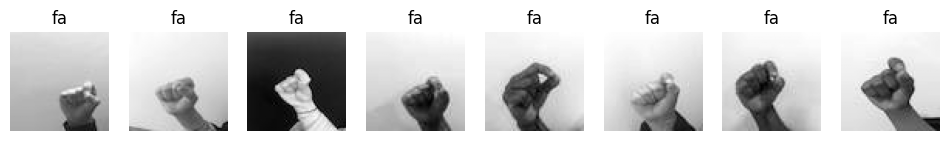

Final total images after cleaning: 48422


In [45]:
classes_clean = sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name)
if classes_clean:
    sample_class = random.choice(classes_clean)
    sample_images = list(sample_class.glob("*.png"))[:8]

    if sample_images:
        plt.figure(figsize=(12, 3))
        for i, img_path in enumerate(sample_images, 1):
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            plt.subplot(1, len(sample_images), i)
            plt.imshow(img, cmap="gray")
            plt.title(sample_class.name)
            plt.axis("off")
        plt.show()
print("Final total images after cleaning:", total_clean)

Total images after cleaning: 48422


,class,count
0,ain,1923
1,ghain,1788
2,fa,1766
3,saad,1702
4,nun,1648
5,ta,1647
6,taa,1645
7,laam,1644
8,bb,1604
9,toot,1602


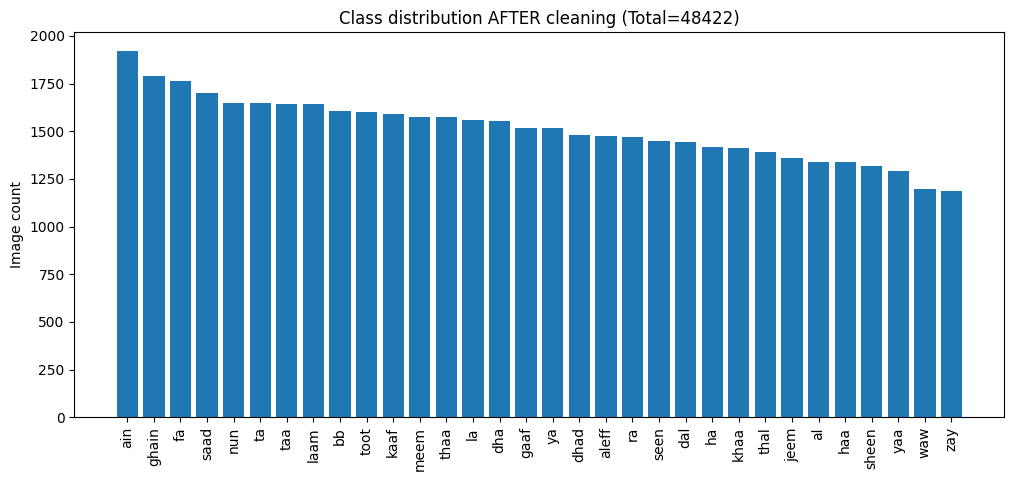

In [48]:
# عدّ الصور في CLEAN_DIR
rows = []
for c in sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name):
    n = sum(1 for p in c.iterdir() if is_image(p))
    rows.append({"class": c.name, "count": n})

df_clean_counts = pd.DataFrame(rows).sort_values("count", ascending=False).reset_index(drop=True)

# إجمالي الصور
total_clean = int(df_clean_counts["count"].sum())
print("Total images after cleaning:", total_clean)
display(df_clean_counts.head(10))   # نعرض أول 10 كلاسات فقط (للإيجاز)

# رسم بسيط
plt.figure(figsize=(12,5))
plt.bar(df_clean_counts["class"], df_clean_counts["count"])
plt.xticks(rotation=90)
plt.ylabel("Image count")
plt.title(f"Class distribution AFTER cleaning (Total={total_clean})")
plt.show()

## Splitting

Split: 80% train, 10% val, 10% test

CONFIG

In [49]:
# CLEAN_DIR هو مجلد النسخة النظيفة اللي خلّصناها بالتنظيف
CLEAN_DIR = Path("./ArASL_Cleaned")      # عدّلي المسار إذا لزم
SPLIT_DIR = Path("./ArASL_Split")        # هنا راح نحط train/val/test
SPLIT_DIR.mkdir(parents=True, exist_ok=True)

#  نسب التقسيم — 80/10/10
TRAIN_RATIO = 0.8
VAL_RATIO   = 0.1
TEST_RATIO  = 0.1
assert abs((TRAIN_RATIO + VAL_RATIO + TEST_RATIO) - 1.0) < 1e-6, "Ratios must sum to 1."

# ثبّت العشوائية
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp"}

def is_image(p: Path) -> bool:
    """Return True if file extension is an image."""
    return p.suffix.lower() in IMG_EXTS

SCAN CLEANED

In [50]:
# نجمع كل الملفات المصنّفة (class folders) من CLEAN_DIR
assert CLEAN_DIR.exists(), f"Cleaned dataset not found: {CLEAN_DIR}"

classes = sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name)
assert classes, "No class folders found in CLEAN_DIR."

items = []
for c in classes:
    for p in c.iterdir():
        if is_image(p):
            items.append({"class": c.name, "path": p})

df = pd.DataFrame(items)
print(f"[INFO] classes: {len(classes)} | images: {len(df)}")

[INFO] classes: 32 | images: 48422


STRATIFIED SPLIT (per class)

In [51]:
#  نقسم داخل كل كلاس إلى 3 قوائم حسب النسب (مع خلط عشوائي ثابت)
def stratified_split_paths(paths, train_ratio, val_ratio, test_ratio, seed=RANDOM_SEED):
    n = len(paths)
    idx = list(range(n))
    random.Random(seed).shuffle(idx)  # تثبيت العشوائية لكل استدعاء
    n_train = int(round(n * train_ratio))
    n_val   = int(round(n * val_ratio))
    n_test  = n - n_train - n_val     # الباقي للتست لتجنب أثر التقريب

    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train+n_val]
    test_idx  = idx[n_train+n_val:]

    train = [paths[i] for i in train_idx]
    val   = [paths[i] for i in val_idx]
    test  = [paths[i] for i in test_idx]
    return train, val, test

REATE DEST FOLDERS


In [52]:
#  نجهّز مجلدات الوجهات لكل split ولكل class
for split in ["train", "val", "test"]:
    for c in classes:
        (SPLIT_DIR / split / c.name).mkdir(parents=True, exist_ok=True)

SPLIT & COPY FILES


In [53]:
#  نقسّم وننسخ الملفات إلى المجلدات المناسبة
split_rows = []

for c in classes:
    cls = c.name
    paths = [p for p in c.iterdir() if is_image(p)]
    train_paths, val_paths, test_paths = stratified_split_paths(
        paths, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, seed=RANDOM_SEED
    )

    # نسخ الملفات
    for split_name, plist in [("train", train_paths), ("val", val_paths), ("test", test_paths)]:
        for src in plist:
            dst = SPLIT_DIR / split_name / cls / src.name
            shutil.copy2(src, dst)
            split_rows.append({"split": split_name, "class": cls, "path": dst})

df_split = pd.DataFrame(split_rows)
print("[INFO] split done.")
print("Target folder:", SPLIT_DIR.resolve())

[INFO] split done.
Target folder: /Users/amirah/Sila/Src/ArASL_Split



COUNTS (PER SPLIT & CLASS)

In [55]:
#  نحسب عدد الصور لكل كلاس داخل كل split
def count_by_split(df_split: pd.DataFrame) -> pd.DataFrame:
    return (df_split.groupby(["split", "class"])["path"].count()
            .reset_index()
            .rename(columns={"path": "count"})
            .sort_values(["split", "class"])
            .reset_index(drop=True))

df_counts = count_by_split(df_split)
display(df_counts)

# NOTE (Arabic): ملخص سريع بعد التقسيم — كم صورة في كل split إجمالًا
summary = (df_split.groupby(["split"])["path"].count()
           .reset_index()
           .rename(columns={"path": "total_images"}))
display(summary)

# نحفظ الجداول كـ CSV مرجع
df_counts.to_csv(SPLIT_DIR / "class_counts_per_split.csv", index=False)
summary.to_csv(SPLIT_DIR / "split_totals.csv", index=False)

,split,class,count
0,test,ain,193
1,test,al,134
2,test,aleff,148
3,test,bb,161
4,test,dal,145
5,test,dha,155
6,test,dhad,149
7,test,fa,176
8,test,gaaf,151
9,test,ghain,179


,split,total_images
0,test,4842
1,train,38738
2,val,4842


VISUALIZE: GROUPED BAR CHART


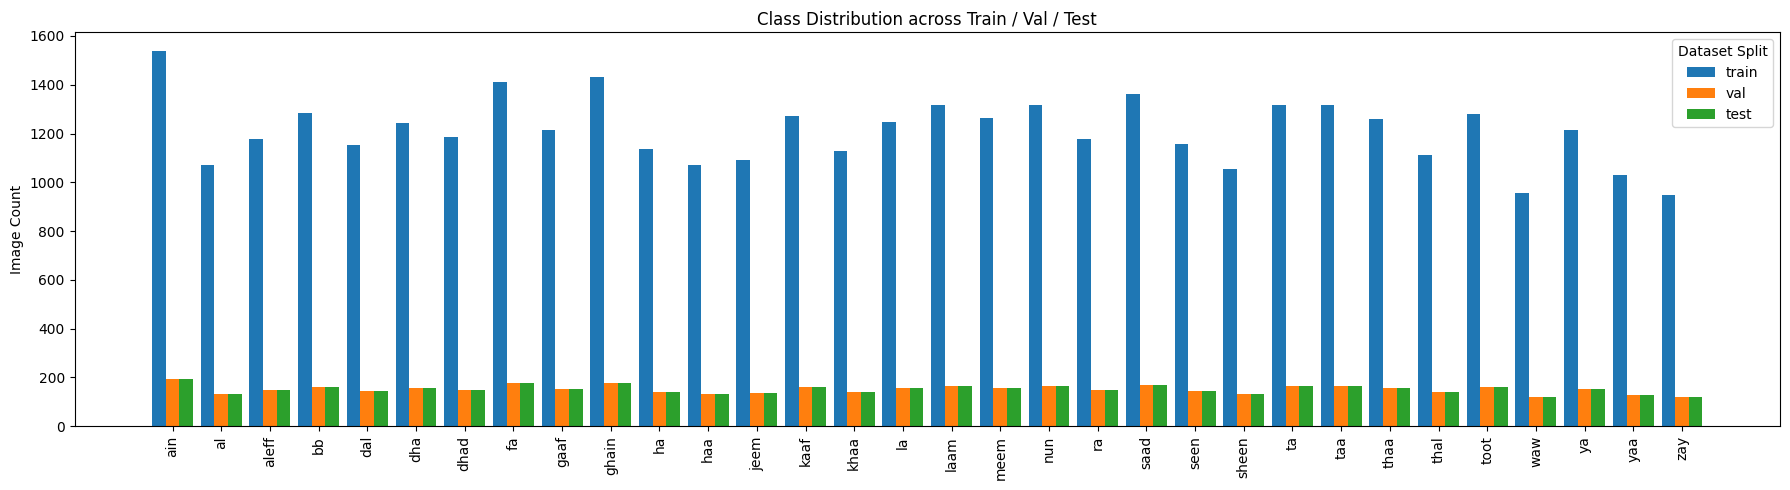

In [56]:
# مقارنة توزيع الكلاسات بين train/val/test (بدون seaborn)
dfp = df_counts.pivot(index="class", columns="split", values="count").fillna(0).sort_index()
splits = ["train", "val", "test"]
classes_order = dfp.index.tolist()

x = np.arange(len(classes_order))
width = 0.28

plt.figure(figsize=(18, 5))
for i, s in enumerate(splits):
    plt.bar(x + (i - 1) * width, dfp[s].values, width, label=s)

plt.xticks(x, classes_order, rotation=90)
plt.ylabel("Image Count")
plt.title("Class Distribution across Train / Val / Test")
plt.legend(title="Dataset Split")
plt.tight_layout()
plt.show()

	تأكيد أن التقسيم فعلاً 80/10/10 لكل كلاس

In [57]:
chk = df_counts.pivot(index="class", columns="split", values="count").fillna(0)
chk["total"] = chk.sum(axis=1)
chk["train%"] = (chk["train"]/chk["total"]*100).round(1)
chk["val%"]   = (chk["val"]/chk["total"]*100).round(1)
chk["test%"]  = (chk["test"]/chk["total"]*100).round(1)
display(chk[["train%","val%","test%"]])

split,train%,val%,test%
class,,,
ain,80.0,10.0,10.0
al,80.0,10.0,10.0
aleff,80.0,10.0,10.0
bb,80.0,10.0,10.0
dal,80.0,10.0,10.0
dha,80.0,10.0,10.0
dhad,80.0,10.0,10.0
fa,80.0,10.0,10.0
gaaf,80.0,10.0,10.0


## Balance 

Balance TRAIN by Augmentation 

In [58]:
SPLIT_DIR          = Path("./ArASL_Split")   # مجلد train/val/test (من خطوة التقسيم)
TRAIN_DIR          = SPLIT_DIR / "train"
TARGET_PER_CLASS   = 1500                    # الهدف لكل كلاس في التدريب (عدّلي الرقم)
RANDOM_SEED        = 42
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp"}

def is_image(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

Balance TRAIN by Augmentation 

,class,count
0,ain,1538
1,al,1500
2,aleff,1500
3,bb,1500
4,dal,1500
5,dha,1500
6,dhad,1500
7,fa,1500
8,gaaf,1500
9,ghain,1500


[INFO] Train total (before): 48038
[INFO] Balancing finished to target: 1500


,class,count
0,ain,1538
1,al,1500
2,aleff,1500
3,bb,1500
4,dal,1500
5,dha,1500
6,dhad,1500
7,fa,1500
8,gaaf,1500
9,ghain,1500


[INFO] Train total (after): 48038


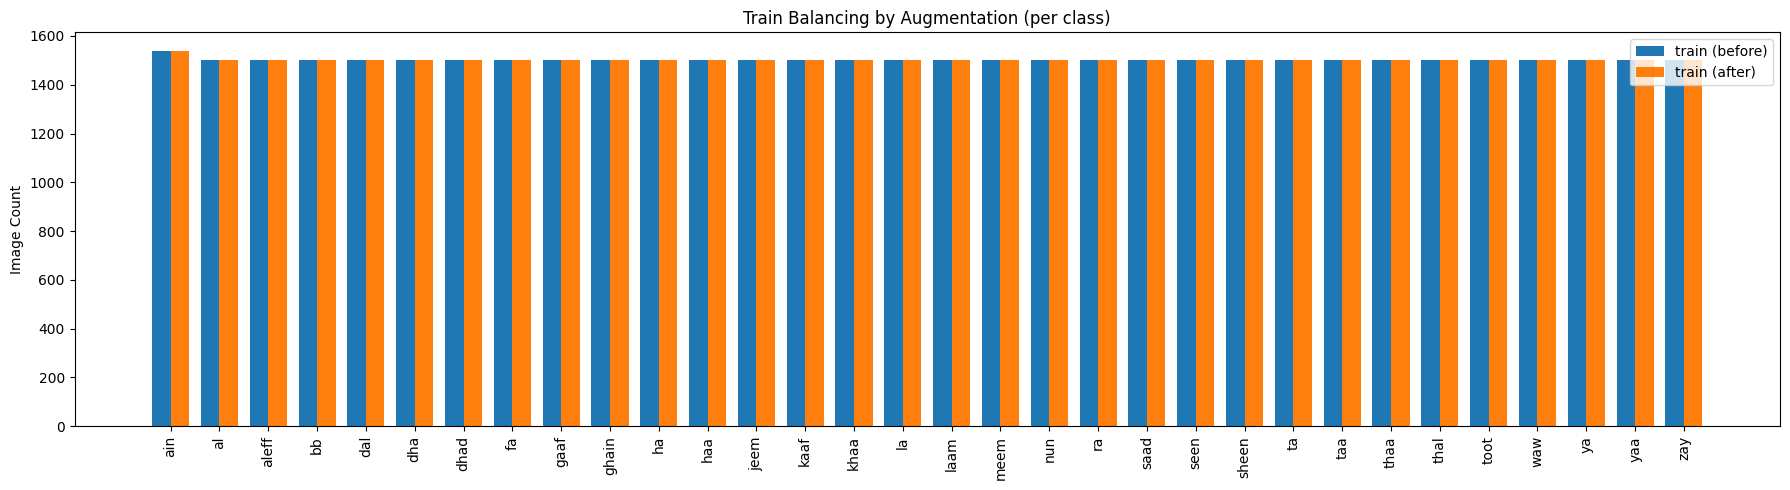

In [60]:
def safe_augment(img):
    # نفترض الصورة رمادية 64x64، لكن نتعامل عام لو كانت ملوّنة
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    out = img.copy()
    h, w = out.shape[:2]

    # 1) دوران بسيط
    angle = random.uniform(-5, 5)
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    out = cv2.warpAffine(out, M, (w, h), borderValue=255)

    # 2) إزاحة بسيطة
    tx = random.randint(-2, 2)
    ty = random.randint(-2, 2)
    M2 = np.float32([[1, 0, tx], [0, 1, ty]])
    out = cv2.warpAffine(out, M2, (w, h), borderValue=255)

    # 3) سطوع/تباين بسيط
    alpha = random.uniform(0.9, 1.1)   # contrast
    beta  = random.randint(-10, 10)    # brightness
    out = cv2.convertScaleAbs(out, alpha=alpha, beta=beta)

    # 4) نويز خفيف
    noise = np.random.normal(0, 3, out.shape).astype(np.float32)
    out = np.clip(out.astype(np.float32) + noise, 0, 255).astype(np.uint8)
    return out

def resize_keep_64(out):
    # NOTE (Arabic): نضمن الحجم 64×64 لو حصل تغير بعد التحويلات
    return cv2.resize(out, (64, 64), interpolation=cv2.INTER_AREA)

# --- احصاء قبل التوازن ---
classes = sorted([d for d in TRAIN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name)
assert classes, "[ERROR] No classes found in train/"

def count_train():
    rows = []
    for c in classes:
        n = sum(1 for p in c.iterdir() if is_image(p))
        rows.append({"class": c.name, "count": n})
    return pd.DataFrame(rows).sort_values("class").reset_index(drop=True)

df_before = count_train()
display(df_before.head(10))
print("[INFO] Train total (before):", int(df_before["count"].sum()))

# --- التوازن: نزيد الكلاسات الأقل حتى TARGET_PER_CLASS ---
for cls_dir in classes:
    imgs = [p for p in cls_dir.iterdir() if is_image(p)]
    cur  = len(imgs)
    if cur >= TARGET_PER_CLASS:
        continue

    # نستخدم فقط الصور الأصلية كمصدر (تجنّب تكدّس augment على augment)
    base_imgs = [p for p in imgs if "_aug_" not in p.stem]
    if not base_imgs:
        base_imgs = imgs  # احتياط

    idx = 0
    need = TARGET_PER_CLASS - cur
    with tqdm(total=need, desc=f"Augment {cls_dir.name}") as bar:
        while cur < TARGET_PER_CLASS and base_imgs:
            src = base_imgs[idx % len(base_imgs)]
            im  = cv2.imread(str(src), cv2.IMREAD_GRAYSCALE)
            if im is None:
                idx += 1
                continue
            aug = safe_augment(im)
            aug = resize_keep_64(aug)

            out_name = f"{src.stem}_aug_{cur}.png"
            out_path = cls_dir / out_name
            cv2.imwrite(str(out_path), aug)

            cur += 1
            idx += 1
            bar.update(1)

print("[INFO] Balancing finished to target:", TARGET_PER_CLASS)
# --- احصاء بعد التوازن + رسم للمقارنة داخل train فقط ---
df_after = count_train()
display(df_after.head(10))
print("[INFO] Train total (after):", int(df_after["count"].sum()))

# رسم مقارنة قبل/بعد (train فقط)
merged = df_before.merge(df_after, on="class", suffixes=("_before", "_after"))
x = np.arange(len(merged))
width = 0.38
plt.figure(figsize=(18,5))
plt.bar(x - width/2, merged["count_before"], width, label="train (before)")
plt.bar(x + width/2, merged["count_after"],  width, label="train (after)")
plt.xticks(x, merged["class"], rotation=90)
plt.ylabel("Image Count")
plt.title("Train Balancing by Augmentation (per class)")
plt.legend()
plt.tight_layout()
plt.show()

## الحين بس ابي اتاكد

1) تأكيد عدم وجود تكرارات داخل CLEAN_DIR (داخل الكلاس وعلى مستوى كل الداتا)

In [61]:
def is_img(p): return p.suffix.lower() in IMG_EXTS

def md5_of_file(path, chunk=1<<20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for ch in iter(lambda: f.read(chunk), b""):
            h.update(ch)
    return h.hexdigest()

# --- per-class duplicates ---
dups_per_class = {}
for c in sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name):
    seen = {}
    for p in tqdm([x for x in c.iterdir() if is_img(x)], desc=f"per-class {c.name}"):
        h = md5_of_file(p)
        if h in seen:
            dups_per_class.setdefault(c.name, []).append(str(p))
        else:
            seen[h] = str(p)

# --- global duplicates (بين الكلاسات) ---
seen_global = {}
dups_global  = []
for c in sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name):
    for p in [x for x in c.iterdir() if is_img(x)]:
        h = md5_of_file(p)
        if h in seen_global and Path(seen_global[h]).parent.name != c.name:
            dups_global.append((seen_global[h], str(p)))
        else:
            seen_global[h] = str(p)

print("[CHECK] per-class duplicates total:", sum(len(v) for v in dups_per_class.values()))
print("[CHECK] cross-class duplicates total:", len(dups_global))

# احفظ تقارير للتوثيق
Path("./clean_logs").mkdir(exist_ok=True)
json.dump(dups_per_class, open("./clean_logs/check_per_class_dups.json","w"), indent=2, ensure_ascii=False)
json.dump(dups_global,  open("./clean_logs/check_cross_class_dups.json","w"), indent=2, ensure_ascii=False)

per-class zay: 100%|██████████| 1186/1186 [00:00<00:00, 14848.56it/s]


[CHECK] per-class duplicates total: 2
[CHECK] cross-class duplicates total: 43


2) تأكيد عدم تسريب بين الـ splits (نفس الصورة ظهرت في train/val/test)

In [62]:
from pathlib import Path
import hashlib

SPLIT_DIR = Path("./ArASL_Split")
IMG_EXTS  = {".png", ".jpg", ".jpeg", ".bmp"}

def is_img(p): return p.suffix.lower() in IMG_EXTS
def md5_of_file(path, chunk=1<<20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for ch in iter(lambda: f.read(chunk), b""):
            h.update(ch)
    return h.hexdigest()

def hash_set(root):
    hs = set()
    for p in root.rglob("*"):
        if p.is_file() and is_img(p):
            try: hs.add(md5_of_file(p))
            except: pass
    return hs

train_h = hash_set(SPLIT_DIR/"train")
val_h   = hash_set(SPLIT_DIR/"val")
test_h  = hash_set(SPLIT_DIR/"test")

print("[LEAK] train ∩ val :", len(train_h & val_h))
print("[LEAK] train ∩ test:", len(train_h & test_h))
print("[LEAK] val   ∩ test:", len(val_h & test_h))

[LEAK] train ∩ val : 8
[LEAK] train ∩ test: 7
[LEAK] val   ∩ test: 0


3) تأكيد المقاس والقناة (64×64، رمادي) في CLEAN_DIR

In [63]:
import cv2
from pathlib import Path

CLEAN_DIR = Path("./ArASL_Cleaned")
bad_shapes = []
bad_modes  = []

for p in CLEAN_DIR.rglob("*.png"):
    im = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)   # نقرأ كما هو
    if im is None:
        continue
    h, w = im.shape[:2]
    if (w, h) != (64, 64):          # مقاس مختلف
        bad_shapes.append(str(p))
    # لو ثلاث قنوات نعدّها مخالفة لأن هدفنا رمادي
    if im.ndim == 3 and im.shape[2] != 1:
        bad_modes.append(str(p))

print("[CHECK] non-64x64 images:", len(bad_shapes))
print("[CHECK] non-grayscale images:", len(bad_modes))

[CHECK] non-64x64 images: 0
[CHECK] non-grayscale images: 0


4) تأكيد الموازنة داخل train (وصلنا للهدف أو قريب منه) + توزيع val/test

In [64]:
def is_img(p): return p.suffix.lower() in IMG_EXTS

def count_split(split):
    rows=[]
    root = SPLIT_DIR / split
    for c in sorted([d for d in root.iterdir() if d.is_dir()], key=lambda p:p.name):
        n = sum(1 for p in c.iterdir() if is_img(p))
        rows.append({"class": c.name, "count": n})
    return pd.DataFrame(rows).sort_values("class").reset_index(drop=True)

df_tr = count_split("train")
df_va = count_split("val")
df_te = count_split("test")

print("train total:", int(df_tr["count"].sum()))
print("val   total:", int(df_va["count"].sum()))
print("test  total:", int(df_te["count"].sum()))

# فحص الموازنة (train)
too_low  = df_tr[df_tr["count"] < TARGET_PER_CLASS]
too_high = df_tr[df_tr["count"] > TARGET_PER_CLASS]
print(f"[BALANCE] train < target ({TARGET_PER_CLASS}):", len(too_low))
print(f"[BALANCE] train > target ({TARGET_PER_CLASS}):", len(too_high))

# تأكيد النِسَب في val/test لكل كلاس (تقريبًا 10%/10%)
chk = pd.concat([
    df_tr.assign(split="train"),
    df_va.assign(split="val"),
    df_te.assign(split="test"),
])
pv = chk.pivot(index="class", columns="split", values="count").fillna(0)
pv["total"]  = pv.sum(axis=1)
pv["train%"] = (pv["train"]/pv["total"]*100).round(1)
pv["val%"]   = (pv["val"]/pv["total"]*100).round(1)
pv["test%"]  = (pv["test"]/pv["total"]*100).round(1)
display(pv[["train%","val%","test%"]].head(10))

train total: 48038
val   total: 4842
test  total: 4842
[BALANCE] train < target (1500): 0
[BALANCE] train > target (1500): 1


split,train%,val%,test%
class,,,
ain,80.0,10.0,10.0
al,84.8,7.6,7.6
aleff,83.6,8.2,8.2
bb,82.4,8.8,8.8
dal,83.8,8.0,8.1
dha,82.9,8.6,8.6
dhad,83.5,8.2,8.3
fa,80.9,9.6,9.5
gaaf,83.2,8.4,8.4


5) (اختياري) رسم سريع يوضّح توازن train بعد الـ augmentation

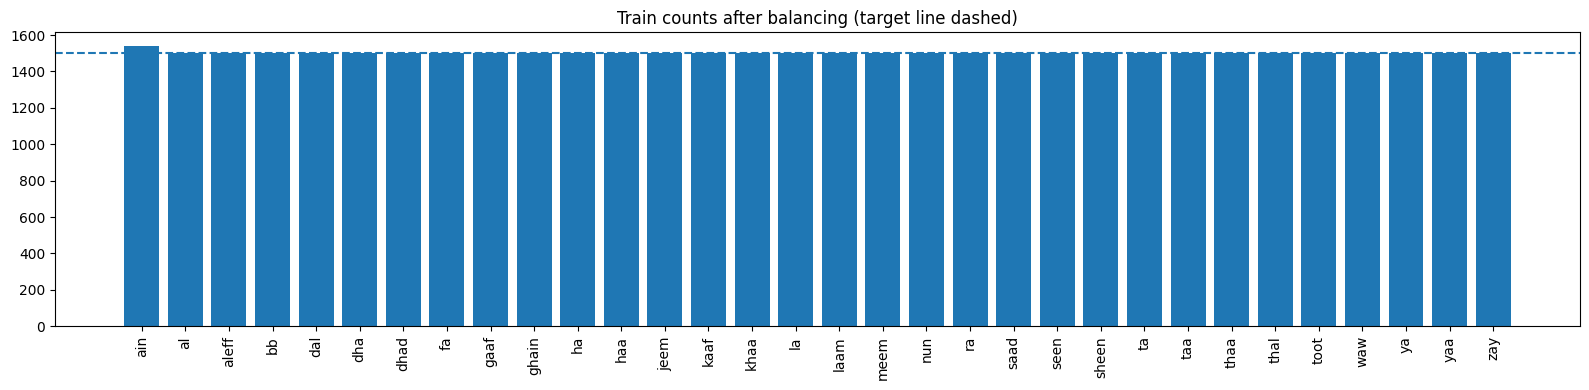

In [65]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(df_tr))
plt.figure(figsize=(16,4))
plt.bar(x, df_tr["count"].values)
plt.xticks(x, df_tr["class"].tolist(), rotation=90)
plt.axhline(TARGET_PER_CLASS, linestyle="--")
plt.title("Train counts after balancing (target line dashed)")
plt.tight_layout(); plt.show()